# Testing the driver code

In [1]:
import sys
sys.path.insert(0, '/Users/ageller/WORK/LSST/onGitHub/EBLSST/code')
from EBLSST import LSSTEBworker, OpSim, TRILEGAL

%load_ext autoreload
%autoreload 2

/Users/ageller/anaconda/envs/py36/lib/python3.6/site-packages/pysynphot/refs.py:118: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /Users/ageller/python_scripts/PySynphotData/mtab/*_tmg.fits
  'functionality will be SEVERELY crippled. ' + str(e))
/Users/ageller/anaconda/envs/py36/lib/python3.6/site-packages/pysynphot/refs.py:125: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /Users/ageller/python_scripts/PySynphotData/mtab/*_tmt.fits
  'no thermal calculations can be performed. ' + str(e))
/Users/ageller/anaconda/envs/py36/lib/python3.6/site-packages/numpy/lib/npyio.py:2222: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)
/Users/ageller/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: Deprecation

*I will do this before initializing the worker, because then I only need to do it once for all processes*

In [2]:
worker = LSSTEBworker()

In [3]:
OpS = OpSim()
OpS.dbFile = '/Users/ageller/WORK/LSST/onGitHub/EBLSST/input/db/minion_1016_sqlite.db' #for the OpSim database	
OpS.getAllOpSimFields()


getting OpSim fields...
have summary cursor.
have field cursor.
returned 5292 fields


*Just for testing so that I don't have to re-download every time*

In [4]:
i=0
gal = TRILEGAL()
gal.RA = OpS.RA[i]
gal.Dec = OpS.Dec[i]
gal.tmpfname = 'TRILEGAL_model_fID'+str(OpS.fieldID[i])+'.h5' 
gal.setModel()


downloading TRILEGAL model for RA=0.0, DEC=-90.0


In [5]:
worker.Galaxy = gal #remove this after testing
worker.OpSim = OpS

#set random seed and get the TRILEGAL model (and get all the fields in OpSim, if not defined already)
#and match to TRILEGAL
worker.initialize(i=0) 

getting Breivik kernel
The number of binaries in the Gx for: 0012 is: 22919080853
both bright stars and eccentric
matching Breivik to TRILEGAL
running emcee with nwalkers=100, nsamples=2000, nthreads=1, 


### Test the output

In [6]:
import corner

from matplotlib import pyplot as plt
#%matplotlib notebook
%matplotlib inline


#some function to make plots (will re-use them later)
#to plot the chains
def plotChains(sampler, nburn, paramsNames):
    Nparams = len(paramsNames)
    fig, ax = plt.subplots(Nparams,1, figsize = (8,2*Nparams), sharex = True)
    fig.subplots_adjust(hspace = 0)
    ax[0].set_title('Chains')
    xplot = range(len(sampler.chain[0,:,0]))

    for i,p in enumerate(paramsNames):
        for w in range(sampler.chain.shape[0]):
            ax[i].plot(xplot[:nburn], sampler.chain[w,:nburn,i], color="0.5", alpha = 0.4, lw = 0.7, zorder = 1)
            ax[i].plot(xplot[nburn:], sampler.chain[w,nburn:,i], color="k", alpha = 0.4, lw = 0.7, zorder = 1)
            
            ax[i].set_ylabel(p)
            
    return ax

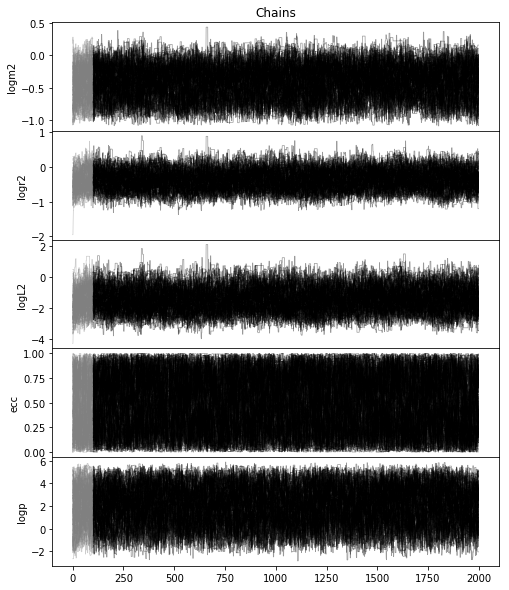

In [7]:
outNames = ['logm2', 'logr2', 'logL2', 'ecc', 'logp']
axC = plotChains(worker.emcee_sampler, worker.emcee_nburn, outNames)

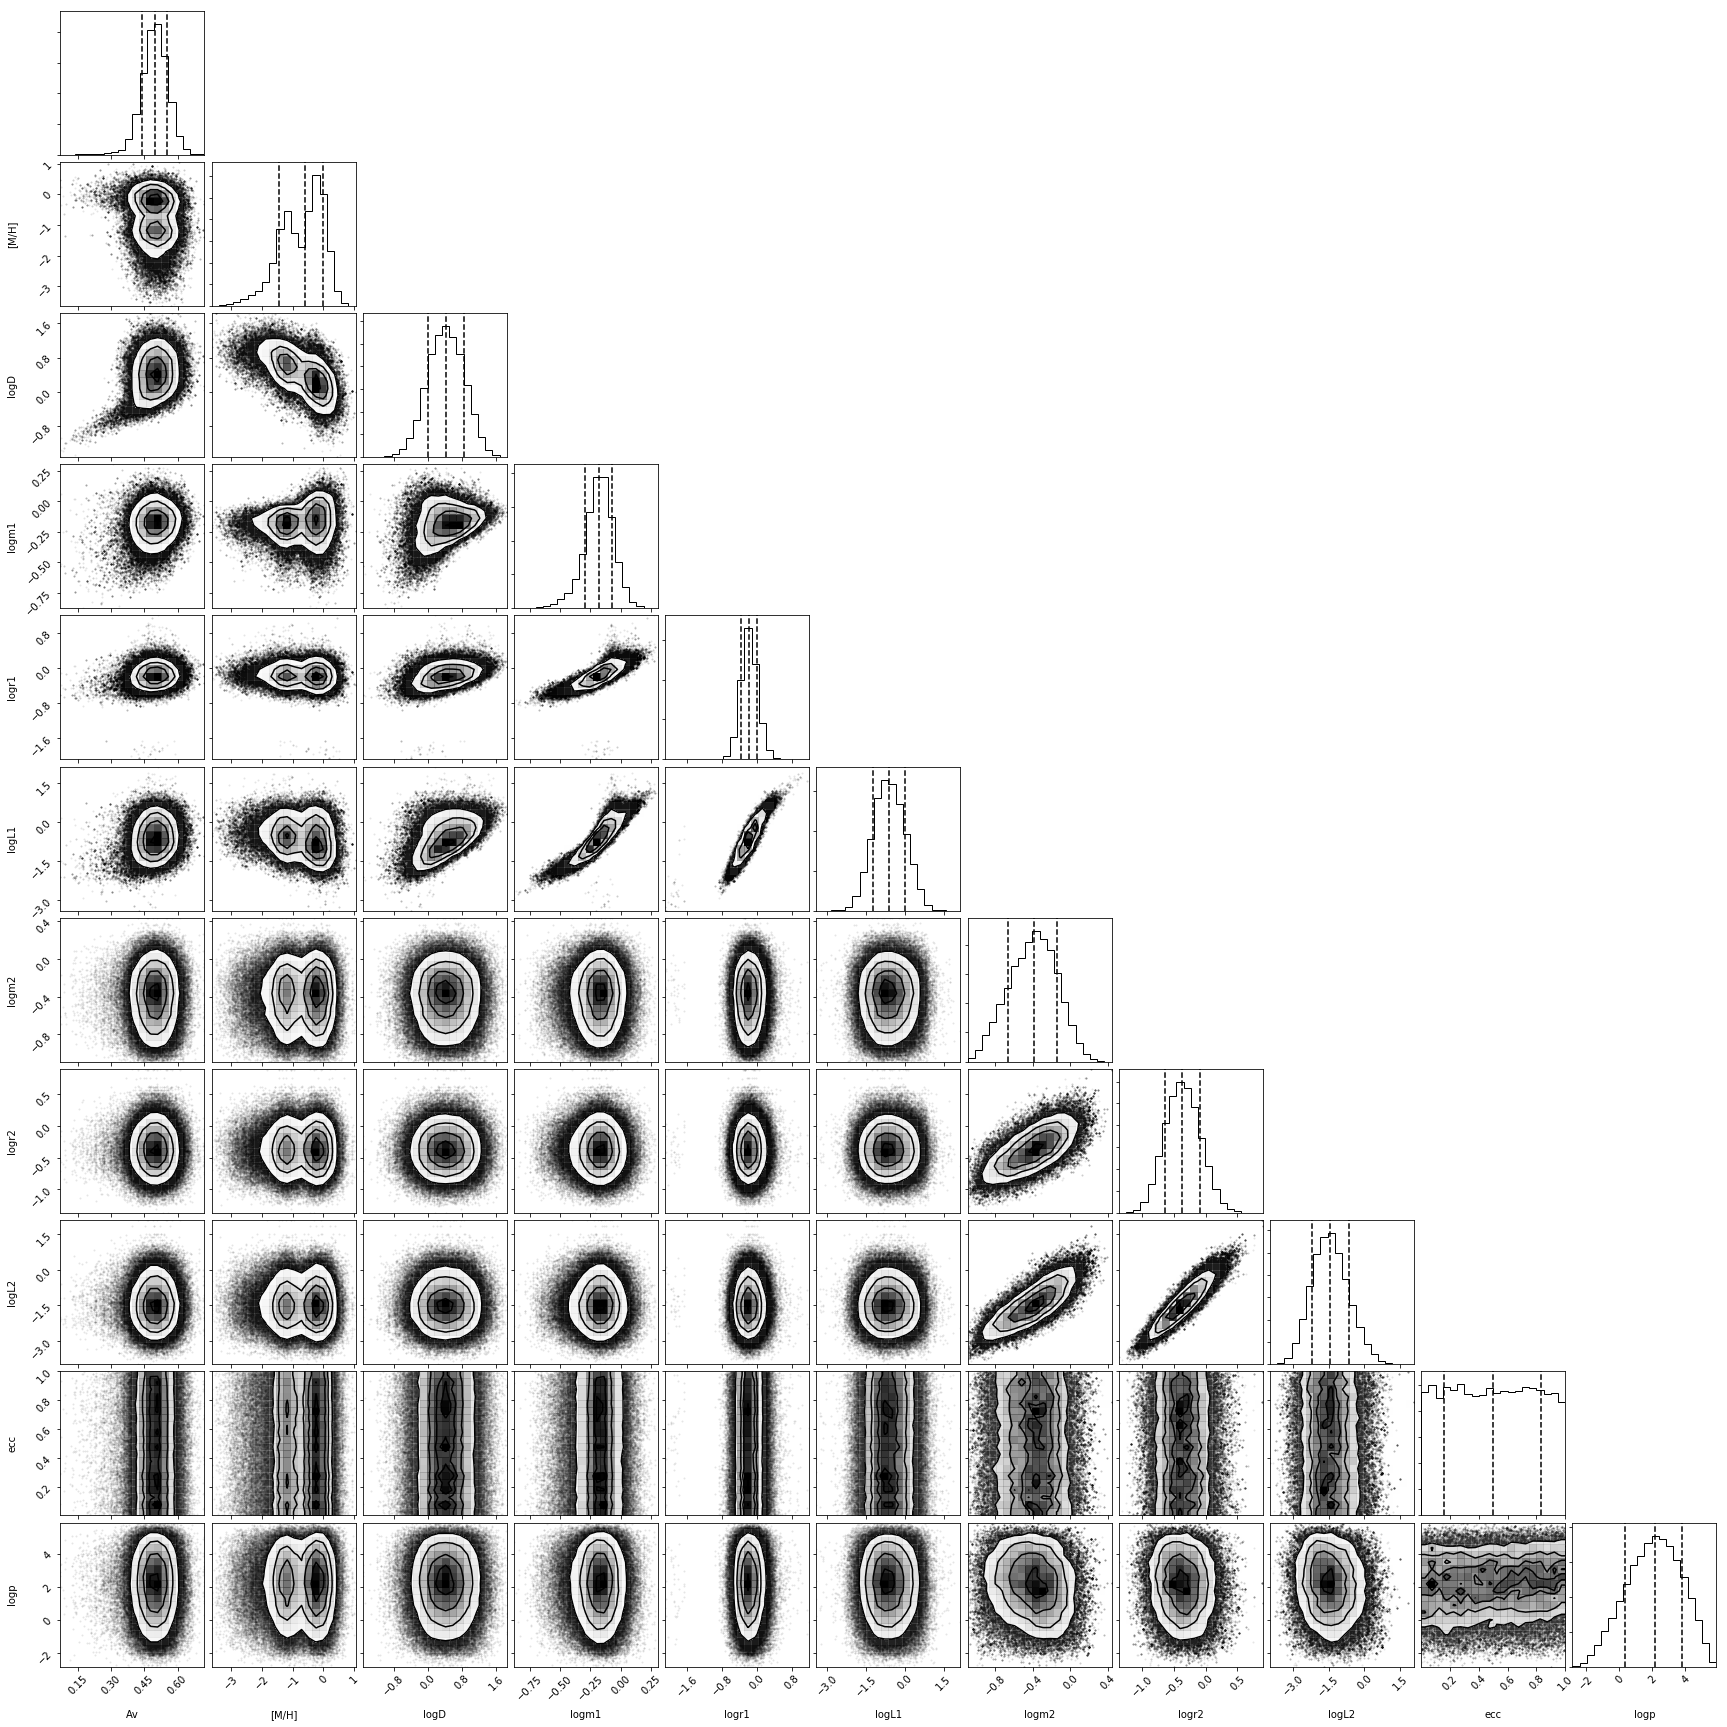

In [8]:
outNames = ['Av', '[M/H]', 'logD', 'logm1', 'logr1', 'logL1', 'logm2', 'logr2', 'logL2', 'ecc', 'logp']
f = corner.corner(worker.BreivikGal, labels = outNames, quantiles = [0.16, 0.5, 0.84])

In [11]:
i = 9
line = worker.sampleBreivikGal()
EB = worker.getEB(line, i)

#TO TEST
EB.inclination = 90.

print(EB.period, EB.inclination, EB.R_1, EB.R_2, EB.sbratio, EB.q)

fig,ax = plt.subplots(6,1, figsize=(6,8))
for i,f in enumerate(worker.filters):
    EB.observe(f)

    ax[i].plot((EB.obsDates[f] % EB.period), EB.appMag[f],'.', color='red')
    ax[i].plot((EB.obsDates[f] % EB.period), EB.appMagObs[f],'.', alpha=0.3, color='blue')
    ax[i].set_ylim(max(EB.appMagObs[f]), min(EB.appMagObs[f]))
    ax[i].set_ylabel(f)

/Users/ageller/WORK/LSST/onGitHub/EBLSST/code/EBLSST.py:398: RuntimeWarning: invalid value encountered in true_divide
  self.q = self.m2/self.m1
/Users/ageller/WORK/LSST/onGitHub/EBLSST/code/EBLSST.py:252: RuntimeWarning: divide by zero encountered in log10
  logTeff = 3.762 + 0.25*np.log10(L) - 0.5*np.log10(R)
/Users/ageller/WORK/LSST/onGitHub/EBLSST/code/EBLSST.py:252: RuntimeWarning: invalid value encountered in log10
  logTeff = 3.762 + 0.25*np.log10(L) - 0.5*np.log10(R)
/Users/ageller/WORK/LSST/onGitHub/EBLSST/code/EBLSST.py:252: RuntimeWarning: invalid value encountered in subtract
  logTeff = 3.762 + 0.25*np.log10(L) - 0.5*np.log10(R)
/Users/ageller/WORK/LSST/onGitHub/EBLSST/code/EBLSST.py:257: RuntimeWarning: divide by zero encountered in log10
  return np.log10(m) + 4.*np.log10(T) - np.log10(L) - 10.6071
/Users/ageller/WORK/LSST/onGitHub/EBLSST/code/EBLSST.py:257: RuntimeWarning: invalid value encountered in log10
  return np.log10(m) + 4.*np.log10(T) - np.log10(L) - 10.6071
/

TypeError: only size-1 arrays can be converted to Python scalars